# Artificial Neural Network

We remind that if the user is using Google Colaboratory, he must change the execution type to GPU, see the README.

In [120]:
#Libraries for data processing
import numpy as np 
import pandas as pd

#Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(color_codes = True)
sns.set(font_scale=1.5) #fixing font size

#Libraries for artificial neural network
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Normalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import Callback

##### We import our training data (all nuclei except Z=10,38,54,68,82) and create rescaled inputs based on the dataframe columns for the ANN

In [121]:
train_data = pd.read_csv("3_rescaled_data/train_rescaled_data.csv", sep=";")

In [122]:
#First inputs
target = train_data["rescaled_ame_BE"]

def create_input_list(dataset,input_names) :
    """This function returns a list of all the inputs in input_names, with the choosen dataset"""
    input_list=[ dataset[i] for i in input_names]
    return input_list

input_names = ["rescaled_N", "rescaled_Z", "rescaled_Surf", 
               "rescaled_Asym", "rescaled_Coul", "rescaled_Pair",
               "rescaled_Z_distance", "rescaled_N_distance"]

inputs = create_input_list(train_data, input_names)

##### We create a function that will create the ANN. It takes 3 parameters: the number of inputs, the number of layers and the number of neurons per layer desired.

In [123]:
def create_model(num_inputs, num_layers, num_neurons):
    inputs = [keras.layers.Input(shape=(1,)) for i in range(num_inputs)]
    merged = keras.layers.Concatenate()(inputs)

    dense = merged
    for i in range(num_layers):
        dense = Dense(num_neurons, kernel_initializer = 'uniform', activation="relu")(dense)
    
    output = Dense(1, kernel_initializer = 'uniform', activation="relu")(dense)
    model = keras.models.Model(inputs, output)
    return model

##### We use this function to create an ANN with 12 inputs, 14 hidden layers with 100 neurons each.

In [124]:
model4 = create_model(8,6,20) 
model4.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_129 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_130 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_131 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_132 (InputLayer)         [(None, 1)]          0           []                               
                                                                                           

In [125]:
model4.compile(optimizer=Adam(learning_rate=0.01), loss="mean_squared_error")

##### We create a class that will allow us to stop the training of the model when a specific loss is reach. Otherwise, the training will continue until the last epoch.

In [126]:
class EarlyStoppingByLossValue(Callback):
    def __init__(self, value=0.00000009):
        self.value = value

    def on_epoch_end(self, epoch, logs={}):
        current_loss = logs.get("loss")
        if current_loss < self.value:
            self.model.stop_training = True
            print("Early stopping by loss value at epoch", epoch)

early_stopping = EarlyStoppingByLossValue()

##### We train the model and plot the evolution of the loss among epochs.

Sometimes when compiling the next code bloc, the loss will be constant. It shouldn't be the case and thus the user has to stop the execution and compile again. It may take some retries before the loss decreases as intended.

Epoch 1/6000
42/42 - 1s - loss: 0.1124 - 875ms/epoch - 21ms/step
Epoch 2/6000
42/42 - 0s - loss: 0.0057 - 91ms/epoch - 2ms/step
Epoch 3/6000
42/42 - 0s - loss: 7.1758e-04 - 97ms/epoch - 2ms/step
Epoch 4/6000
42/42 - 0s - loss: 4.0899e-04 - 89ms/epoch - 2ms/step
Epoch 5/6000
42/42 - 0s - loss: 3.0117e-04 - 94ms/epoch - 2ms/step
Epoch 6/6000
42/42 - 0s - loss: 2.0727e-04 - 83ms/epoch - 2ms/step
Epoch 7/6000
42/42 - 0s - loss: 2.8225e-04 - 79ms/epoch - 2ms/step
Epoch 8/6000
42/42 - 0s - loss: 1.4393e-04 - 82ms/epoch - 2ms/step
Epoch 9/6000
42/42 - 0s - loss: 2.0380e-04 - 81ms/epoch - 2ms/step
Epoch 10/6000
42/42 - 0s - loss: 1.0342e-04 - 85ms/epoch - 2ms/step
Epoch 11/6000
42/42 - 0s - loss: 3.7315e-04 - 96ms/epoch - 2ms/step
Epoch 12/6000
42/42 - 0s - loss: 2.1626e-04 - 96ms/epoch - 2ms/step
Epoch 13/6000
42/42 - 0s - loss: 7.7294e-05 - 90ms/epoch - 2ms/step
Epoch 14/6000
42/42 - 0s - loss: 1.1175e-04 - 89ms/epoch - 2ms/step
Epoch 15/6000
42/42 - 0s - loss: 1.1056e-04 - 88ms/epoch - 2ms/

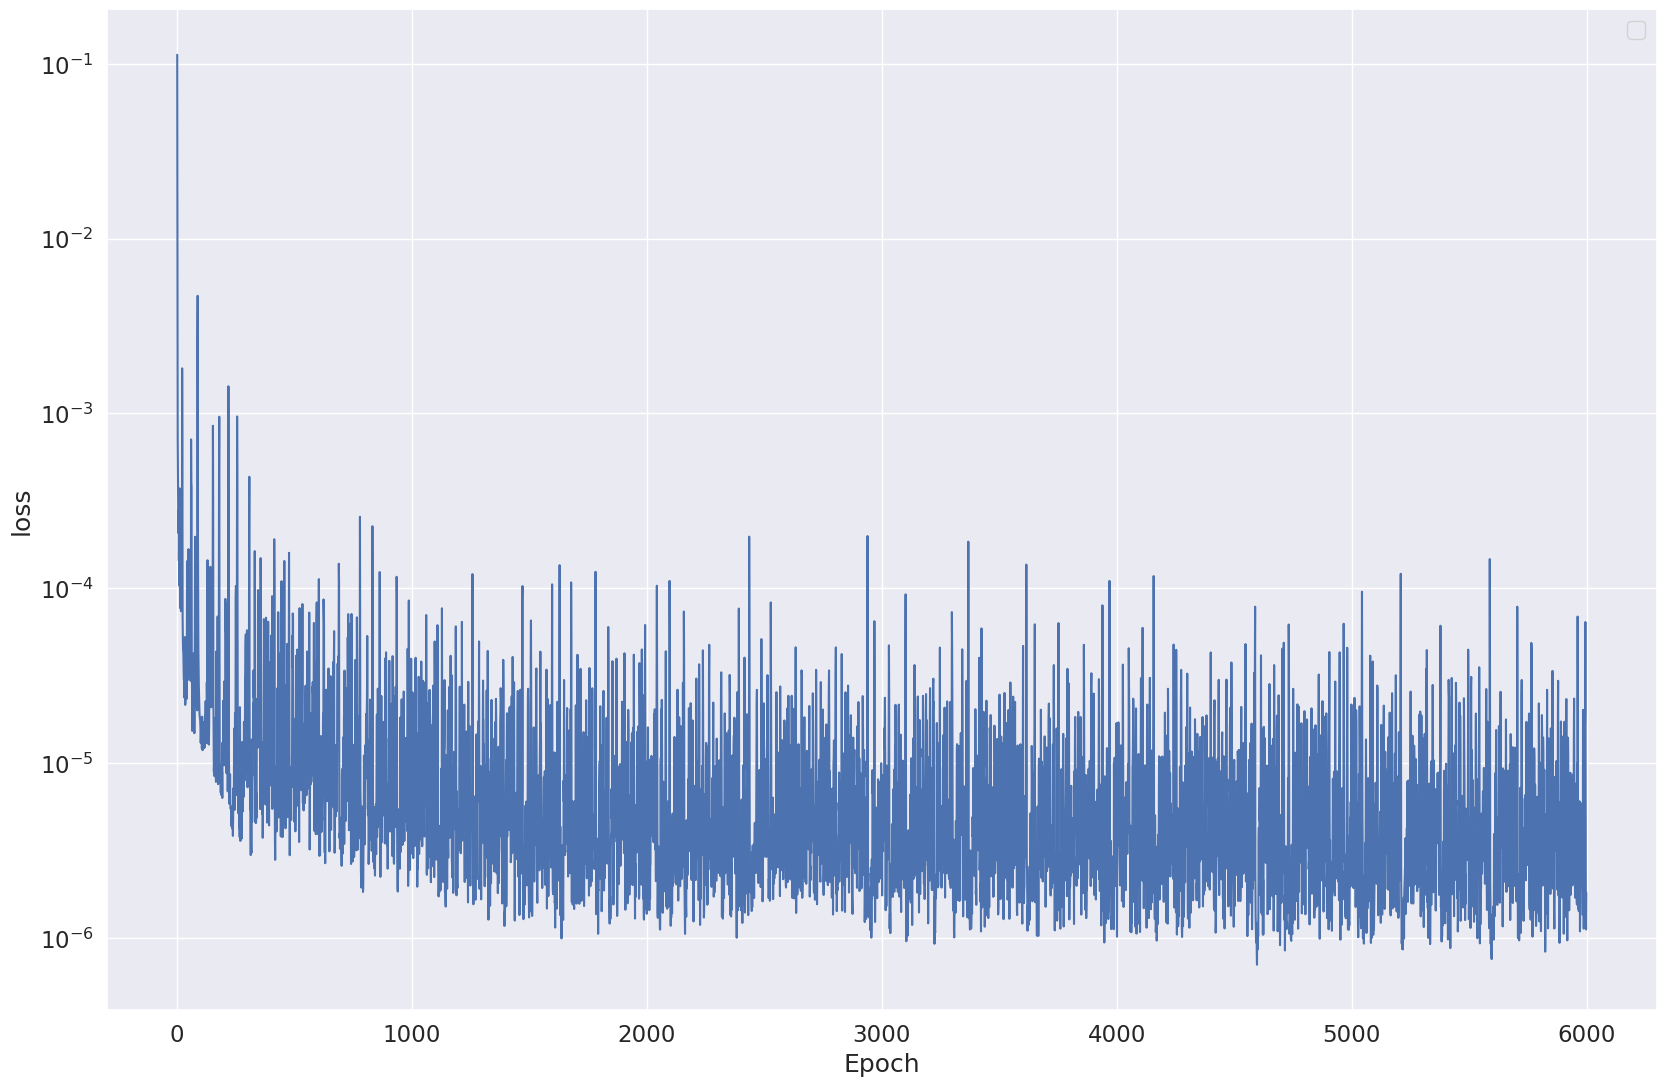

In [127]:
history4=model4.fit(x=inputs, y=target,
                    batch_size=64, epochs=6000, shuffle=True,
                    verbose=2, callbacks=[early_stopping] )

plt.figure(figsize =(20,13))
plt.yscale('log')
plt.legend('labels')

plt.plot(history4.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()
#Be careful : loss is mean_squared_error, not RMSE

##### We rescale the target data.

In [128]:
scaler = MinMaxScaler(feature_range=(0,1))

rescaled_data = pd.read_csv("3_rescaled_data/rescaled_data.csv", sep=";")

rescaled_target = scaler.fit_transform(pd.Series.to_numpy(rescaled_data["ame_BE"]).reshape(-1,1))

#### Here, we predict the binding energy for all the nuclei used for training, and we compute the difference between the prediction and experimental data.

In [129]:
train_predictions = model4.predict(x=inputs, verbose=0)


train_rescaled_predictions = [(i - scaler.min_)/scaler.scale_ for i in train_predictions]


train_data["BE_Predictions"] = np.double(train_rescaled_predictions)
train_data["Difference_BE_AME_ANN"] = train_data["ame_BE"] - train_data["BE_Predictions"]
train_data["Difference_BE_DZ_ANN"] = train_data["dz_BE"] - train_data["ame_BE"]

##### We will now do the same operation as above, but we will use the model to predict binding energies for the nuclei it has never trained on (Z=10,38,54,68,82) (test data)

In [130]:
test_data = pd.read_csv("3_rescaled_data/test_rescaled_data.csv", sep=";")

test_target = test_data["rescaled_ame_BE"]

test_inputs = create_input_list(test_data, input_names)

In [131]:
test_predictions = model4.predict(x=test_inputs, verbose=0)

test_rescaled_predictions = [ (i - scaler.min_)/scaler.scale_ for i in test_predictions]

test_data["BE_Predictions"] = np.double(test_rescaled_predictions)
test_data["Difference_BE_AME_ANN"] = test_data["ame_BE"] - test_data["BE_Predictions"]


##### Here, we compute the values for Sn, Sp, S2n et S2p with the predicted binding energies for both datasets (training and test)

In [132]:
train_data=train_data.sort_values(by=['A','N'], ascending=True)

In [133]:
train_data=train_data.sort_values(by=['N','Z'], ascending=True)
train_data['Prediction_S2p'] = train_data['BE_Predictions'] - train_data['BE_Predictions'].shift(2)

train_data = train_data.sort_values(by=['A','N'], ascending=True)
train_data['Prediction_S2n'] = train_data['BE_Predictions'] - train_data['BE_Predictions'].shift(2)
train_data['Prediction_S1n'] = train_data['BE_Predictions'] - train_data['BE_Predictions'].shift(1)

train_data["Difference_S2n_AME_Predictions"] = train_data["ame_S2n"] - train_data["Prediction_S2n"]
train_data["Difference_S2p_AME_Predictions"] = train_data["ame_S2p"] - train_data["Prediction_S2p"]

train_data["Difference_S2n_DZ_Predictions"] = train_data["dz_S2n"] - train_data["Prediction_S2n"]
train_data["Difference_S2p_DZ_Predictions"] = train_data["dz_S2p"] - train_data["Prediction_S2p"]

In [134]:
test_data.sort_values(by=['N','Z'], ascending=True)
test_data['Prediction_S2p'] = test_data['BE_Predictions'] - test_data['BE_Predictions'].shift(2)

test_data = test_data.sort_values(by=['A','N'], ascending=True)
test_data['Prediction_S2n'] = test_data['BE_Predictions'] - test_data['BE_Predictions'].shift(2)
test_data['Prediction_S1n'] = test_data['BE_Predictions'] - test_data['BE_Predictions'].shift(1)

test_data["Difference_S2n_AME_Predictions"] = test_data["ame_S2n"] - test_data["Prediction_S2n"]
test_data["Difference_S2p_AME_Predictions"] = test_data["ame_S2p"] - test_data["Prediction_S2p"]

test_data["Difference_S2n_DZ_Predictions"] = test_data["dz_S2n"] - test_data["Prediction_S2n"]
test_data["Difference_S2p_DZ_Predictions"] = test_data["dz_S2p"] - test_data["Prediction_S2p"]

#### We save the predictions into .csv and we will plot them on another notebook

In [135]:
train_final_csv = train_data.to_csv("4_final_data/train_final_data.csv",sep=";")
test_final_csv = test_data.to_csv("4_final_data/test_final_data.csv",sep=";")